Ariane is taking a vacation in Deep Bay.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib.patches as patches
from salishsea_tools import viz_tools, geo_tools, tidetools
from bathy_helpers import *
import matplotlib.path as mpltPath

In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')

### 407 particles were released at various depthts at time=0 in the following domain marked by the black rectangle.  

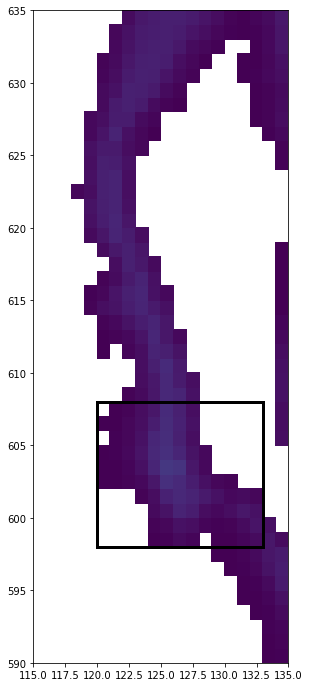

In [3]:
fig, ax = plt.subplots(1,1, figsize=(16,12))
ax.pcolormesh(grid.variables['Bathymetry'][:])
ax.set_ylim(590,635)
ax.set_xlim(115,135)
viz_tools.set_aspect(ax)
ax.add_patch(patches.Rectangle((120,598), 13, 10, fill=False, linewidth=3))

In [4]:
July = nc.Dataset('/results/SalishSea/hindcast/01jul16/SalishSea_1h_20160701_20160701_grid_T.nc')
ssh = July.variables['sossheig']

In [6]:
ssh

<class 'netCDF4._netCDF4.Variable'>
float32 sossheig(time_counter, y, x)
    standard_name: sea_surface_height_above_geoid
    long_name: sea surface height
    units: m
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 h
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (24, 898, 398)
filling on

In [16]:
with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea201702.nc', 'r') as cnc:
    glamf = cnc.variables['glamf'][0,...]; gphif = cnc.variables['gphif'][0,...]
    glamt = cnc.variables['glamt'][0,...]; gphit = cnc.variables['gphit'][0,...]
NY, NX = glamt.shape[0], glamt.shape[1]
glamfe, gphife = expandf(glamf, gphif)

In [4]:
result = nc.Dataset('/ocean/vdo/MEOPAR/ariane-runs/weeklong/ariane_trajectories_qualitative.nc')

In [99]:
latt = result.variables['traj_lat']
lont = result.variables['traj_lon']

In [100]:
bathy, lons, lats = tidetools.get_bathy_data(grid)

In [13]:
%%timeit
number_of_particles = np.zeros(168)
for n in range(168):
    for m in range(407):
        if (lont[:].mask[n,m]) == False: 
            y,x = geo_tools.find_closest_model_point(lont[n,m],latt[n,m],lons, lats, land_mask=bathy.mask)
            if (598<y<608) and (120<x<133):
                number_of_particles[n] = number_of_particles[n] + 1

1 loop, best of 3: 2min 46s per loop


In [23]:
%%timeit
number_of_particles2=np.zeros(168)
for l in range (168):
    xarray, yarray = getboxij(glamfe, gphife, lont[l,:], latt[l,:])
    a = np.array((xarray, yarray)).T
    a = a[ (608>a[:,1]) & (a[:,1]>598) ]
    a = a[ (133>a[:,0]) & (a[:,0]>120) ]
    p,q = a.shape
    number_of_particles2[l]=p

/home/vdo/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


1 loop, best of 3: 6min 37s per loop


In [47]:
def still_inside2(time):
    number_of_particles2=np.zeros(time)
    for l in range (time):
        xarray, yarray = getboxij(glamfe, gphife, lont[l,:], latt[l,:])
        a = np.array((xarray, yarray)).T
        a = a[ (608>a[:,1]) & (a[:,1]>598) ]
        a = a[ (133>a[:,0]) & (a[:,0]>120) ]
        p,q = a.shape
        number_of_particles2[l]=p
    return number_of_particles2
still_inside2(2)

array([ 401.,  396.])

In [46]:
mask = lont[:].mask
def still_inside(time, number):
    number_of_particles = np.zeros(time)
    for n in range(time):
        for m in range(number):
            if (mask[n,m]) == False:
                y,x = geo_tools.find_closest_model_point(lont[n,m],latt[n,m],lons, lats, land_mask=bathy.mask)
                if (598<y<658) and (118<x<134):
                    number_of_particles[n] = number_of_particles[n] + 1
    return number_of_particles

still_inside(2,407)

array([ 402.,  399.])

In [43]:
b = still_inside2(168)

/home/vdo/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


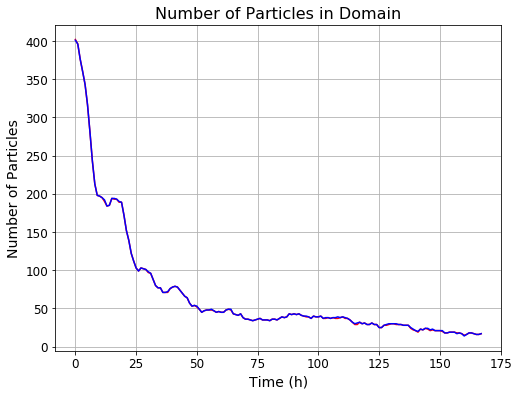

In [44]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
time = range(168)
ax.plot(time, number_of_particles, 'r-')
ax.plot(time, b, 'b-')
ax.grid('on')
ax.set_title('Number of Particles in Domain', fontsize=16)
ax.set_ylabel('Number of Particles', fontsize=14)
ax.set_xlabel('Time (h)', fontsize=14)
ax.tick_params(labelsize=12)
#plt.savefig('Arianeresult.png', bbox_inches='tight')

In [9]:
index_deep_particles=[]
for n in range(407):
    if result.variables['init_z'][n] > 6:
        index_deep_particles.append(n)

In [10]:
number_of_deep_particles = np.zeros(168)
for n in range(168):
    for m in index_deep_particles:
        if (lont[:].mask[n,m]) == False: 
            y,x = geo_tools.find_closest_model_point(lont[n,m],latt[n,m],lons, lats, land_mask=bathy.mask)
            if (598<y<608) and (120<x<133):
                number_of_deep_particles[n] = number_of_deep_particles[n] + 1

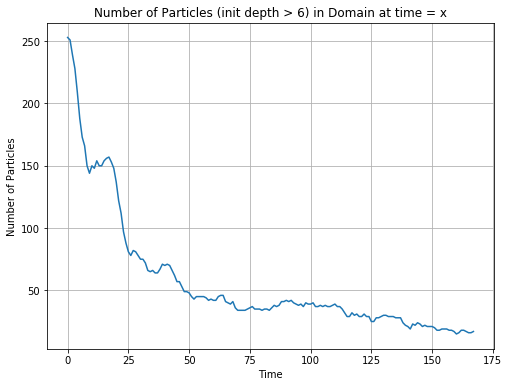

In [11]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
time = range(168)
ax.plot(time, number_of_deep_particles)
ax.grid('on')
ax.set_title('Number of Particles (init depth > 6) in Domain at time = x')
ax.set_ylabel('Number of Particles')
ax.set_xlabel('Time')

In [15]:
index_shallow_particles=[]
for n in range(407):
    if result.variables['init_z'][n] < 6:
        index_shallow_particles.append(n)

In [16]:
number_of_shallow_particles = np.zeros(168)
for n in range(168):
    for m in index_shallow_particles:
        if (lont[:].mask[n,m]) == False: 
            y,x = geo_tools.find_closest_model_point(lont[n,m],latt[n,m],lons, lats, land_mask=bathy.mask)
            if (598<y<608) and (120<x<133):
                number_of_shallow_particles[n] = number_of_shallow_particles[n] + 1

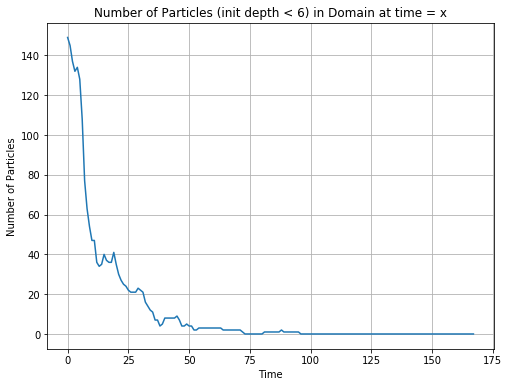

In [17]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
time = range(168)
ax.plot(time, number_of_shallow_particles)
ax.grid('on')
ax.set_title('Number of Particles (init depth < 6) in Domain at time = x')
ax.set_ylabel('Number of Particles')
ax.set_xlabel('Time')